In [1]:
%%time
from time import time
import warnings
warnings.filterwarnings('ignore')
import ml_metrics as metrics
import pandas as pd
import numpy as np
from sklearn import cross_validation, ensemble, tree, preprocessing, neighbors, naive_bayes, svm
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
le = preprocessing.LabelEncoder()
import xgboost as xgb
from datetime import datetime, date
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

CPU times: user 909 ms, sys: 235 ms, total: 1.14 s
Wall time: 1.72 s


In [2]:
%%time
import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

CPU times: user 12 µs, sys: 1e+03 ns, total: 13 µs
Wall time: 17.9 µs


In [ ]:
%%time
ids = []
predictions = []

In [3]:
%%time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

CPU times: user 30.3 s, sys: 5.85 s, total: 36.2 s
Wall time: 39.1 s


In [ ]:
%%time
for i in np.arange(2.5,5,.25):
    for r in np.arange(0,10,.25):
        train_reduced = train[(train.x >= i) & (train.x <= (i + .25)) & (train.y >= r) & (train.y <= (r + .25))]
        if i == 9.75 and r == 9.75:
            test_reduced = test[(test.x >= i) & (test.x <= (i + .25)) & (test.y >= r) & (test.y <= (r + .25))]
        elif i == 9.75:
            test_reduced = test[(test.x >= i) & (test.x <= (i + .25)) & (test.y >= r) & (test.y < (r + .25))]
        elif r == 9.75:
            test_reduced = test[(test.x >= i) & (test.x < (i + .25)) & (test.y >= r) & (test.y <= (r + .25))]
        else:
            test_reduced = test[(test.x >= i) & (test.x < (i + .25)) & (test.y >= r) & (test.y < (r + .25))]
#         small_counts = train_reduced['place_id'].value_counts()
#         print 'Test: ',i, (i + .5), r, (r + .5), len(train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)]), len(test_reduced)
        print 'Test: ',i, (i + .25), r, (r + .25), len(train_reduced), len(test_reduced)
#         train_reduced['day_number'] = ((train_reduced['time']/60)//24).astype(int)
        train_reduced['seconds'] = (train_reduced['time'] * 60)
        train_reduced['date_time'] = pd.to_datetime(train_reduced['seconds'],unit='s')
        train_reduced['hour'] = train_reduced['date_time'].dt.hour
        train_reduced['day'] = train_reduced['date_time'].dt.day
        train_reduced['dow'] = train_reduced['date_time'].dt.dayofweek
        train_reduced.x.replace(0, .0001, inplace=True)
        train_reduced.y.replace(0, .0001, inplace=True)
        train_reduced['div']= (train_reduced.x / train_reduced.y)
        train_reduced['multi']= (train_reduced.x * train_reduced.y)
        train_reduced['squadd']= (train_reduced.x**2 + train_reduced.y**2)
        
#         test_reduced['day_number'] = ((test_reduced['time']/60)//24).astype(int)
        test_reduced['seconds'] = (test_reduced['time'] * 60)
        test_reduced['date_time'] = pd.to_datetime(test_reduced['seconds'],unit='s')
        test_reduced['hour'] = test_reduced['date_time'].dt.hour
        test_reduced['day'] = test_reduced['date_time'].dt.day
        test_reduced['dow'] = test_reduced['date_time'].dt.dayofweek
        test_reduced.x.replace(0, .0001, inplace=True)
        test_reduced.y.replace(0, .0001, inplace=True)
        test_reduced['div']= (test_reduced.x / test_reduced.y)
        test_reduced['multi']= (test_reduced.x * test_reduced.y)
        test_reduced['squadd']= (test_reduced.x**2 + test_reduced.y**2)
        features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow', 'div', 'multi', 'squadd']]
#         features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow']]
#         bayes = naive_bayes.GaussianNB().fit(train_reduced[features], train_reduced['place_id'])
        forest = ensemble.RandomForestClassifier(n_estimators=70, min_samples_leaf=5, n_jobs=-1).fit(train_reduced[features], train_reduced['place_id'])
#         forest = ensemble.RandomForestClassifier(n_estimators=20, n_jobs=-1).fit(train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)][features], train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)]['place_id'])
        probs = pd.DataFrame(forest.predict_proba(test_reduced[features]))
#         probs.columns = np.unique(train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)]['place_id'].values)
        probs.columns = np.unique(train_reduced['place_id'].sort_values().values)
        preds = pd.DataFrame([list([p.sort_values(ascending=False)[:3].index.values]) for x,p in probs.iterrows()])
        #pred = clf_rf.predict(test_reduced[features])
        print 'All Good: ',i, (i + .25), r, (r + .25), len(test_reduced['row_id']), len(preds)
        ids.append(list(test_reduced['row_id'].values))
        predictions.append(preds[0])

In [ ]:
print len(ids), len(predictions)

In [ ]:
%%time
ids = [val for sublist in ids for val in sublist]
predictions = [val for sublist in predictions for val in sublist]

In [ ]:
print len(ids), len(predictions)

In [ ]:
%%time
submission = pd.DataFrame()
submission['row_id'] = ids
submission['place_id'] = [' '.join(str(x) for x in y) for y in predictions]

In [ ]:
%%time
submission.head()

In [ ]:
%%time
submission.to_csv('submissions/submission-0-2.5.csv', index=False)

In [ ]:
%%time
submission_1 = pd.read_csv('submissions/submission-0-2.csv')
submission_2 = pd.read_csv('submissions/submission-2-4.csv')
submission_3 = pd.read_csv('submissions/submission-4-6.csv')
submission_4 = pd.read_csv('submissions/submission-6-8.csv')
submission_5 = pd.read_csv('submissions/submission-8-10.csv')

In [ ]:
%%time
submission_concat = pd.concat([submission_1,submission_2,submission_3,submission_4, submission_5], ignore_index=True)

In [ ]:
%%time
submission_concat.sort_values('row_id', inplace=True)

In [ ]:
%%time
print len(test), len(submission_concat)

In [ ]:
submission_concat.head()

In [ ]:
%%time
submission_concat.to_csv('final_submission.csv', index=False)

In [74]:
%%time
# Test:  2.0 2.25 1.0 1.25 22684 5978
# Test:  1.75 2.0 9.5 9.75 21100 6806
train_reduced = train[(train.x >= 1) & (train.x < 1.1) & (train.y >= 2.5) & (train.y < 2.6)]

CPU times: user 318 ms, sys: 545 ms, total: 863 ms
Wall time: 980 ms


In [75]:
%%time
# train_reduced['day_number'] = ((train_reduced['time']/60)//24).astype(int)
train_reduced['seconds'] = (train_reduced['time'] * 60)
train_reduced['date_time'] = pd.to_datetime(train_reduced['seconds'],unit='s')
train_reduced['hour'] = train_reduced['date_time'].dt.hour
train_reduced['day'] = train_reduced['date_time'].dt.day
train_reduced['dow'] = train_reduced['date_time'].dt.dayofweek
train_reduced.x.replace(0, .0001, inplace=True)
train_reduced.y.replace(0, .0001, inplace=True)
train_reduced['div']= (train_reduced.x / train_reduced.y)
train_reduced['multi']= (train_reduced.x * train_reduced.y)
train_reduced['squadd']= (train_reduced.x**2 + train_reduced.y**2)
train_reduced['acc_squ'] = (train_reduced.accuracy**2 / (train_reduced.x / train_reduced.y))
train_reduced['acc_x'] = (train_reduced.accuracy * train_reduced.x)
train_reduced['acc_y'] = (train_reduced.accuracy * train_reduced.y)

CPU times: user 567 ms, sys: 15.4 ms, total: 583 ms
Wall time: 623 ms


In [76]:
features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow', 'div', 'multi', 'squadd', 'acc_squ', 'acc_x', 'acc_y']]

In [77]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.60)

CPU times: user 8.19 ms, sys: 1.83 ms, total: 10 ms
Wall time: 9.14 ms


In [78]:
%%time
# estimators = [20,30,40,50,60,65,70]
# for estimator in estimators :
t0 = time()
forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
probs = pd.DataFrame(forest.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print "Estimators:", estimator, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
print "Done in:",round(time()-t0,3),"s"

Estimators: 70 MapK: 0.642618251314
Done in: 1.203 s
CPU times: user 1.26 s, sys: 158 ms, total: 1.42 s
Wall time: 1.2 s


Feature ranking:
1. feature 1 - y (0.220735)
2. feature 8 - squadd (0.170212)
3. feature 6 - div (0.108722)
4. feature 7 - multi (0.100707)
5. feature 3 - hour (0.096442)
6. feature 0 - x (0.087642)
7. feature 9 - acc_squ (0.044467)
8. feature 10 - acc_x (0.042927)
9. feature 11 - acc_y (0.039968)
10. feature 2 - accuracy (0.036932)
11. feature 5 - dow (0.031126)
12. feature 4 - day (0.020120)


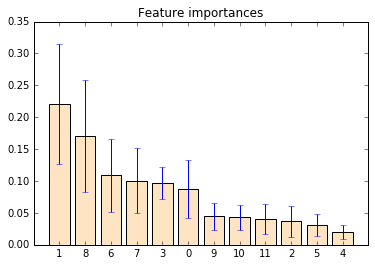

In [79]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(features_train.shape[1]):
    print("%d. feature %d - %s (%f)" % (f + 1, indices[f], features_train.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(features_train.shape[1]), importances[indices],
       color="bisque", yerr=std[indices], align="center")
plt.xticks(range(features_train.shape[1]), indices)
plt.xlim([-1, features_train.shape[1]])
plt.show()

In [63]:
train_reduced[features].head()

,x,y,accuracy,hour,day,dow,div,multi,squadd,acc_squ,acc_x,acc_y
1070,2.0568,1.0406,7,21,30,0,1.976552,2.140306,5.313275,24.790646,14.3976,7.2842
1332,2.0819,1.0337,18,1,28,1,2.014027,2.152060,5.402843,160.871704,37.4742,18.6066
3933,2.0638,1.0326,136,15,5,2,1.998644,2.131080,5.325533,9254.273476,280.6768,140.4336
16872,2.0426,1.0454,67,6,4,2,1.953893,2.135334,5.265076,2297.464310,136.8542,70.0418
19876,2.0231,1.0527,1,16,7,4,1.921820,2.129717,5.201111,0.520340,2.0231,1.0527


In [21]:
%%time
sample_leaf_options = [1,5,10,50,100,200,500]
for leaf_size in sample_leaf_options:
    t0 = time()
    forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=leaf_size, n_jobs=-1).fit(features_train, labels_train)
    probs = pd.DataFrame(forest.predict_proba(features_test))
    probs.columns = np.unique(labels_train.sort_values().values)
    preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
    print "Leafs:", leaf_size, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
    print "Done in:",round(time()-t0,3),"s"

Leafs: 1 MapK: 0.588170416588
Done in: 11.282 s
Leafs: 5 MapK: 0.603527236823
Done in: 8.599 s
Leafs: 10 MapK: 0.593170311548
Done in: 8.102 s
Leafs: 50 MapK: 0.54758303397
Done in: 7.415 s
Leafs: 100 MapK: 0.512226633894
Done in: 7.405 s
Leafs: 200 MapK: 0.464118400874
Done in: 7.705 s
Leafs: 500 MapK: 0.360643683956
Done in: 7.537 s
CPU times: user 1min 22s, sys: 18.7 s, total: 1min 40s
Wall time: 58 s


In [185]:
%%time
# Test:  2.0 2.25 1.0 1.25 22684 5978
# Test:  1.75 2.0 9.5 9.75 21100 6806
# estimators = [20,30,40,50,60,65,70]
for i in np.arange(4,5,.1):
    train_reduced = train[(train.x >= 4) & (train.x <= 4.1) & (train.y >= i) & (train.y <= (i + .1))]
    t0 = time()
    train_reduced['seconds'] = (train_reduced['time'] * 60)
    train_reduced['date_time'] = pd.to_datetime(train_reduced['seconds'],unit='s')
    train_reduced['hour'] = train_reduced['date_time'].dt.hour
    train_reduced['day'] = train_reduced['date_time'].dt.day
    train_reduced['dow'] = train_reduced['date_time'].dt.dayofweek
    train_reduced.x.replace(0, .0001, inplace=True)
    train_reduced.y.replace(0, .0001, inplace=True)
    train_reduced['div']= (train_reduced.x / train_reduced.y)
    train_reduced['multi']= (train_reduced.x * train_reduced.y)
    train_reduced['squadd']= (train_reduced.x**2 + train_reduced.y**2)
    train_reduced['acc_squ'] = (train_reduced.accuracy**2 / (train_reduced.x / train_reduced.y))
    train_reduced['acc_x'] = (train_reduced.accuracy * train_reduced.x)
    train_reduced['acc_y'] = (train_reduced.accuracy * train_reduced.y)
    features = [c for c in train_reduced.columns if c in ['x', 'y', 'accuracy', 'hour', 'day', 'dow', 'div', 'multi', 'squadd', 'acc_squ', 'acc_x', 'acc_y']]
    features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
    forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
    probs = pd.DataFrame(forest.predict_proba(features_test))
    probs.columns = np.unique(labels_train.sort_values().values)
    preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
    print "Estimators:", 60, "MapK:", mapk([[l] for l in labels_test], preds[0], 3)
    print "Done in:",round(time()-t0,3),"s"

Estimators: 60 MapK: 0.605316529045
Done in: 1.791 s
Estimators: 60 MapK: 0.369638635596
Done in: 1.226 s
Estimators: 60 MapK: 0.653373463757
Done in: 1.788 s
Estimators: 60 MapK: 0.630403130403
Done in: 2.265 s
Estimators: 60 MapK: 0.632043842682
Done in: 1.909 s
Estimators: 60 MapK: 0.550853150611
Done in: 1.782 s
Estimators: 60 MapK: 0.59426107642
Done in: 1.701 s
Estimators: 60 MapK: 0.503251342946
Done in: 1.275 s
Estimators: 60 MapK: 0.475933908046
Done in: 1.335 s
Estimators: 60 MapK: 0.535040431267
Done in: 1.49 s
CPU times: user 20.2 s, sys: 3.56 s, total: 23.7 s
Wall time: 21.4 s


In [ ]:
%%time
# neigh = neighbors.KNeighborsClassifier(weights='distance', n_jobs=-1).fit(features_train, labels_train)
forest = ensemble.RandomForestClassifier(n_estimators=60, min_samples_leaf=5, n_jobs=-1).fit(features_train, labels_train)
# bayes = naive_bayes.GaussianNB().fit(features_train.toarray(), labels_train)
# boost = xgb.XGBClassifier(learning_rate=1,
#                           n_estimators=10,
#                           max_depth=5,
#                           min_child_weight=1,
#                           gamma=0,
#                           subsample=0.8,
#                           colsample_bytree=0.8,
#                           nthread=4,
#                           scale_pos_weight=1,
#                           seed=27,
#                           objective='multi:softprob').fit(features_train, labels_train)
#  learning_rate = 1,
#  max_depth=5,
#  min_child_weight=1,
#  gamma=0,
#  subsample=0.8,
#  colsample_bytree=0.8,
#  objective= 'multi:softprob',
#  nthread=4,
#  scale_pos_weight=1,
#  seed=27).fit(features_train, labels_train)

In [ ]:
print train_reduced['date_time'].min(), train_reduced['date_time'].max()

In [ ]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.day_number, bins=100, histtype = 'step')
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.dow, bins=7)
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
plt.rcParams["figure.figsize"] = [12,9]
plt.hist(train_reduced.hour, bins=24)
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
plt.rcParams["figure.figsize"] = [12,9]
plt.scatter(train_reduced.x,train_reduced.y, c=train_reduced.place_id)
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
%%time
small_counts = train_reduced['place_id'].value_counts()
small_trainz = train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 100].index)]
print len(small_trainz)

In [ ]:
small_counts.describe()

In [ ]:
%%time
small_counts = train_reduced['place_id'].value_counts()
small_trainz = train_reduced[train_reduced['place_id'].isin(small_counts[small_counts > 600].index)]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# ax.scatter(small_trainz.x, small_trainz.y, zs=small_trainz.hour, zdir='z', s=20, c=small_trainz.place_id, depthshade=True)
ax.scatter(train_reduced.x, train_reduced.y, zs=train_reduced.hour, zdir='z', s=20, c=train_reduced.place_id, depthshade=True)
plt.autoscale(enable=True, axis='both', tight=True)

In [ ]:
%%time
labels = train_reduced['place_id']
train_ids = train_reduced['row_id']
train_reduced = train_reduced[features]
# Transform the string labels to numerical using label encoder 
train_reduced.hour = le.fit_transform(train_reduced.hour)
train_reduced.day = le.fit_transform(train_reduced.day)
train_reduced.dow = le.fit_transform(train_reduced.dow)

categ = [list(train_reduced.columns).index(x) for x in 'hour', 'dow', 'day']
enc = preprocessing.OneHotEncoder(categorical_features = categ)
train_reduced['hour'] = pd.factorize(train_reduced['hour'])[0]
train_reduced['day'] = pd.factorize(train_reduced['day'])[0]
train_reduced['dow'] = pd.factorize(train_reduced['dow'])[0]
train_reduced = enc.fit_transform(train_reduced)
print train_reduced.shape

In [ ]:
%%time
labels = train_reduced['place_id']
train_ids = train_reduced['row_id']
train_reduced = train_reduced[features]

In [ ]:
%%time
features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(train_reduced[features], train_reduced['place_id'], test_size=0.70)
# features_train, features_test, labels_train, labels_test = cross_validation.train_test_split(features_train, labels_train, test_size=0.60)

In [ ]:
%%time
probs = pd.DataFrame(boost.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(forest.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(bayes.predict_proba(features_test.toarray()))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)

In [ ]:
%%time
probs = pd.DataFrame(neigh.predict_proba(features_test))
probs.columns = np.unique(labels_train.sort_values().values)
#probs.columns = np.unique(labels_train.values)
preds = pd.DataFrame([list([r.sort_values(ascending=False)[:3].index.values]) for i,r in probs.iterrows()])
print mapk([[l] for l in labels_test], preds[0], 3)